In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset,DataLoader,Subset
from PIL import Image
# import tensorflow as tf
import matplotlib.pyplot as plt
from torchvision import transforms
from torchmetrics.functional import accuracy


ModuleNotFoundError: No module named 'torchmetrics'

In [10]:
import os
import pandas as pd
import numpy as np


class myDataset(Dataset):
    """Return : label, PILImages, target""" 
    def __init__(self,image_folder_path:str,classes:list,transform = None,random_seed = None):
        self.classes = classes
        self.key = {c : i+1 for i,c in enumerate(self.classes)} # i+1 : gaussian label = [1.,0.,0...,0]
        self.class_pathes = [os.path.join(image_folder_path,cla)for cla in classes]
        self.df = pd.DataFrame([[i+1,os.path.join(cla,file)] for i,cla in enumerate(self.class_pathes) for file in os.listdir(cla)])
        self.label = self.df.iloc[:,0]
        self.files = self.df.iloc[:,1]
        self.transform = transform
        self.random_seed = random_seed
        
    def __getitem__(self, index: int):
        if self.random_seed:
            np.random.seed(self.random_seed)
            index = np.random.randint(0,len(self.df)-1)
        label = self.df.iloc[index,0]
        image_value = Image.open(self.df.iloc[index,1])
        if self.df.iloc[index,1].endswith('.tif'):
            image_value = np.array(image_value)
        target = torch.zeros(len(self.classes)+1)
        target[label] = 1
        
        if self.transform:
            image_value = self.transform(image_value)
        
        return label,image_value,target
         
    def __len__(self):
        return len(self.df)
    
    def plot_image(self,index):
        image = (np.array(Image.open(self.files[index])))/255.
        plt.title('label : '+str(self.label[index]))
        plt.imshow(image)
                

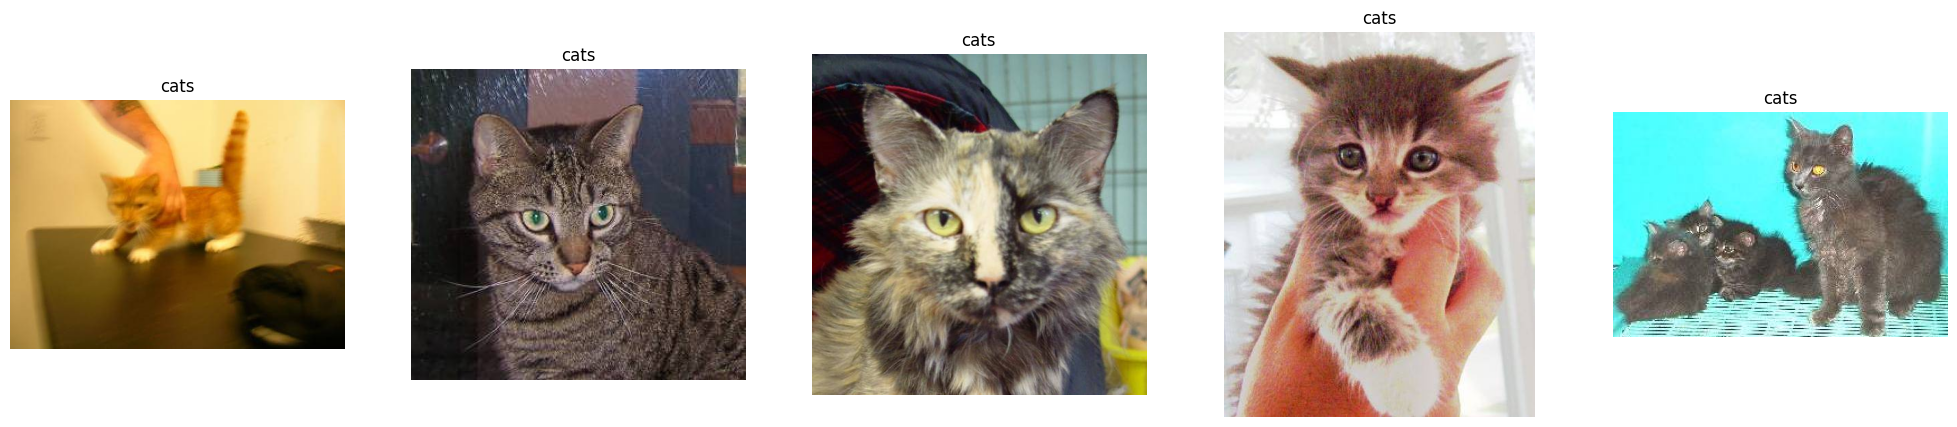

In [11]:
PATH = r'C:\Users\zxcas\PythonWork\DATASETS\Forgery\copymove_img'
#['img'] 

path = './data/train'
classes = ['cats','dogs']
dataset_test = myDataset(path,classes,random_seed=None)
fig, axs = plt.subplots(1, 5, figsize=(25, 5), squeeze=False)
for i,data in enumerate(dataset_test):
    label,image_tensor,target_tenso = data
    if i > 4:break  
    axs[0,i].set_title(str(classes[label-1]))
    axs[0,i].imshow(image_tensor)
    axs[0,i].axis('off')
    # print(image_tensor.size)
    test = image_tensor
plt.show()
      

In [34]:
dataset_test.df

,0,1
0,1,./data/train\cats\cat.0.jpg
1,1,./data/train\cats\cat.1.jpg
2,1,./data/train\cats\cat.10.jpg
3,1,./data/train\cats\cat.100.jpg
4,1,./data/train\cats\cat.101.jpg
...,...,...
595,2,./data/train\dogs\dog.95.jpg
596,2,./data/train\dogs\dog.96.jpg
597,2,./data/train\dogs\dog.97.jpg
598,2,./data/train\dogs\dog.98.jpg


In [57]:
class OCCNN(nn.Module):


    def __init__(self,loss = nn.CrossEntropyLoss(),input_shape=(224,224,3)):
        super(OCCNN,self).__init__()
        self.loss_function = loss
        self.input_shape = input_shape
        vgg = models.vgg16(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = False
        vgg.classifier = nn.Sequential(vgg.classifier[:-5])
        self.model = vgg
        
    def forward(self,x):
        return self.model(x)
    
class Classifier(nn.Module):
    
    
    def __init__(self,num_feature=3): # 2 label, 1 gaussina label
        self.num_feature = num_feature
        super(Classifier,self).__init__()
        self.layers = nn.Sequential(nn.Linear(in_features=4096,out_features=256),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(256,128),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(128,self.num_feature),
                                    #    nn.Softmax(dim=0) # loss function : nn.CrossEntropyLoss()
                                       )
        
    def forward(self,x):
        
        return self.layers(x)

class BACKBONE (nn.Module):
    

    def __init__(self):
        super(BACKBONE,self).__init__()
        vgg = models.vgg16(True)
        for param in vgg.parameters():
            param.requires_grad = False
        vgg.classifier = nn.Sequential(vgg.classifier[:-5])
        self.model = vgg
    
    def forward(self,x):
        return self.model(x)


In [8]:
class_list = ['cats','dogs']
num_feature = len(class_list)+1 # occ : 2 bon : 3
# dataset
transform = transforms.Compose([#transforms.ToPILImage(),
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                     std = [0.229, 0.224, 0.225])])

In [ ]:
def backbone_test():
    test_model = OCCNN()
    tr = transform
    dataset_test = myDataset(path,classes,random_seed=None,transform=transform)

    dataset = DataLoader(Subset(dataset_test,np.arange(500)),32,num_workers=0,shuffle=True)
    clf = Classifier(num_feature=2)

    if torch.cuda.is_available():
        test_model.cuda()
        clf.cuda()
        device = torch.device("cuda:0")
    else:
        print('cuda is not available.') 
        return

    test_model.train()
    clf.train()

    clf_optimiser = torch.optim.Adam(clf.parameters(),1e-4)
    cross_etp_criterion = nn.CrossEntropyLoss()
    inm  = nn.InstanceNorm1d(1, affine=False)

    counter = 0
    progress_loss = []
    progress_acc = []

    for i in range(40):
        for label,x_train,target in dataset_test:
            counter +=1
            bat_size = 32

            # labels = np.concatenate((np.zeros((bat_size,)),label.numpy()),axis=0) # [fake, input]
            labels = np.concatenate((np.zeros((bat_size,)),np.ones((bat_size,))),axis=0) # [fake, input]
            
            labels = torch.from_numpy(labels)       
            labels = torch.autograd.Variable(labels.cuda()).long()

            gaussian_data = np.random.normal(0,0.1,(bat_size,4096))
            gaussian_data = torch.from_numpy(gaussian_data)
            
            x_train.requiers_grad = True
            out1 = test_model(x_train.to(device))
            out1 = out1.view(bat_size, 1, 4096)
            out1 = inm(out1)
            out1 = out1.view(bat_size, 4096)

            out2 = gaussian_data.float().to(device)
            out2.requires_grad = True
            out = torch.cat((out2,out1),0)
            out = clf(out)
    
            clf_optimiser.zero_grad()
    
            loss = cross_etp_criterion(out,labels) 
            loss.backward()
            
            clf_optimiser.step() # train only clf
            
            running_acc = accuracy(nn.functional.softmax(out,dim=-1),labels,top_k=2)

            if counter % 5 == 0:
                progress_loss.append(loss.item())
                progress_acc.append(running_acc.item())
                print(f'counter={counter} loss : {loss}, acc : {running_acc}')
        print(f'epoch : {i} done.')        
    print('done.') 
backbone_test()

In [58]:
# dataset
# transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
class_list = ['cats'] # OCC
num_feature = len(class_list)+1 # occ : 2 bon : 3
# dataset
transform = transforms.Compose([#transforms.ToPILImage(),
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                     std = [0.229, 0.224, 0.225])])

train_dataset = myDataset('./data/train',class_list,transform)
td = Subset(train_dataset,np.arange(300))
# test_dataset = myDataset('./data/test',['cats','dogs','raccoons'],transform)
train_dataloder = DataLoader(td,batch_size=32,num_workers=0,shuffle=True)
# test_dataloder = DataLoadbat_size=32,num_workers=0)


# network train
model = OCCNN()
classifier = Classifier(num_feature=num_feature)
inm  = nn.InstanceNorm1d(1, affine=False)

if torch.cuda.is_available():
    # GPU available
    device = torch.device("cuda:0")
    model.cuda()
    classifier.cuda()

model.train()
classifier.train()

classifier_optimiser = torch.optim.Adam(classifier.parameters(),lr=1e-4)
cross_entropy_criterion = nn.CrossEntropyLoss()

counter = 0
progress_loss = []
progress_acc = []

for i in range(40):
    for label,x_train,target in train_dataloder:
        counter +=1
        bat_size = len(label)

        # set label
        labels = np.concatenate((np.zeros((bat_size,)),np.ones((bat_size,))),axis=0) # [outlier, normal]
        labels = torch.from_numpy(labels).cuda()
        labels.requires_grad = True
        labels = labels.long()

        # generate outlier's feature vectors 
        gaussian_data = np.random.normal(0,0.1,(bat_size,4096))
        gaussian_data = torch.from_numpy(gaussian_data)
        
        
        x_train.requiers_grad = True
        out1 = model(x_train.to(device))
        out1 = out1.view(bat_size, 1, 4096)
        out1 = inm(out1)
        out1 = out1.view(bat_size, 4096)

        out2 = gaussian_data.float().to(device)
        out2.requires_grad = True
        out = torch.cat((out2,out1),0)
        out = nn.ReLU()(out)
        out = classifier(out)
  
        classifier_optimiser.zero_grad()
  
        loss = cross_entropy_criterion(out,labels) 
        loss.backward()
        
        classifier_optimiser.step() # train only clf
        
        running_acc = accuracy(nn.functional.softmax(out,dim=-1),labels,top_k=1)
        
        if counter % 5 == 0:
            progress_loss.append(loss.item())
            progress_acc.append(running_acc.item())
            print(f'counter={counter} loss : {loss}, acc : {running_acc}')
        break
    print(f'epoch : {i} done.')        
print('done.')

epoch : 0 done.
epoch : 1 done.
epoch : 2 done.
epoch : 3 done.
counter=5 loss : 0.5469590425491333, acc : 1.0
epoch : 4 done.
epoch : 5 done.
epoch : 6 done.
epoch : 7 done.
epoch : 8 done.
counter=10 loss : 0.4277503490447998, acc : 1.0
epoch : 9 done.
epoch : 10 done.
epoch : 11 done.
epoch : 12 done.
epoch : 13 done.
counter=15 loss : 0.3623672425746918, acc : 1.0
epoch : 14 done.
epoch : 15 done.
epoch : 16 done.
epoch : 17 done.
epoch : 18 done.
counter=20 loss : 0.32508552074432373, acc : 1.0
epoch : 19 done.
epoch : 20 done.
epoch : 21 done.
epoch : 22 done.
epoch : 23 done.
counter=25 loss : 0.29317936301231384, acc : 1.0
epoch : 24 done.
epoch : 25 done.
epoch : 26 done.
epoch : 27 done.
epoch : 28 done.
counter=30 loss : 0.2745324671268463, acc : 1.0
epoch : 29 done.
epoch : 30 done.
epoch : 31 done.
epoch : 32 done.
epoch : 33 done.
counter=35 loss : 0.24850472807884216, acc : 1.0
epoch : 34 done.
epoch : 35 done.
epoch : 36 done.
epoch : 37 done.
epoch : 38 done.
counter=4

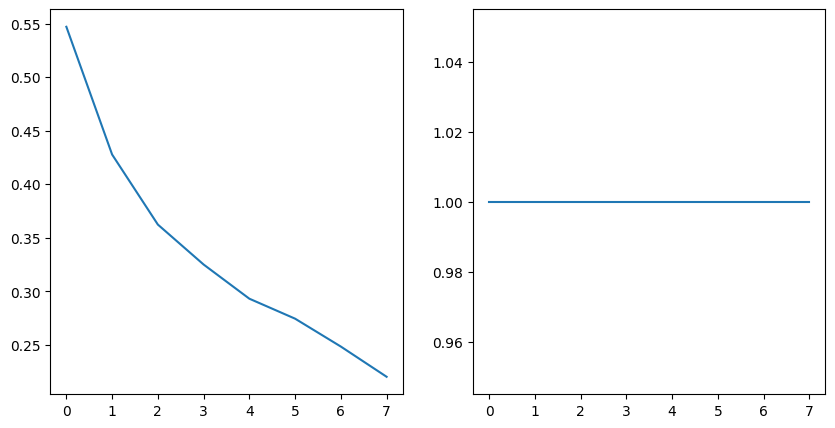

In [59]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(progress_loss)
plt.subplot(122)
plt.plot(progress_acc)

plt.show()

In [60]:
from sklearn.metrics import classification_report

def test():
    
    classifier.eval().cuda()
    model.eval().cuda()
    t = np.array([])
    p = np.array([])

    #                           1      2       3
    for i,clas in enumerate([['cats'],['dogs'],['raccoons']]):

        test_dataset = myDataset('./data/test',clas,transform)
        test_dataloder = DataLoader(test_dataset,batch_size=32,num_workers=0)
        pred = []
        true = []
        
        for _,images,_ in test_dataloder:

            output = model(images.cuda()) 
            output = classifier(output)
            output = nn.Softmax(dim=-1)(output).cpu()
            pred.append(torch.max(output,1)[1].numpy().tolist())
            
        pred = np.array([item for sublist in pred for item in sublist]).reshape((-1,))
        
        if i == 0:
            true = np.ones_like(pred)
        else: 
            true = np.zeros_like(pred)
        t = np.concatenate((t,true))
        p = np.concatenate((p,pred))
    

    report = classification_report(t,p)

    return report ,t,p
report,t,p = test()


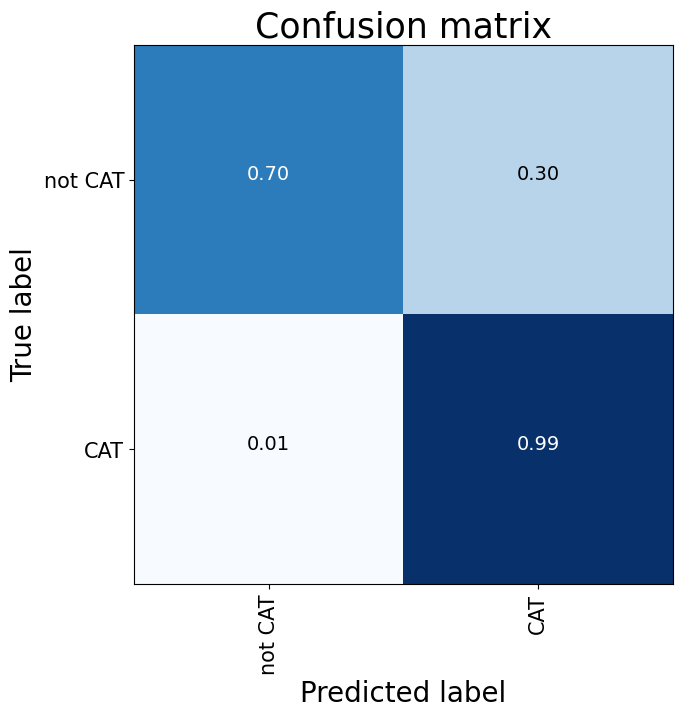

In [61]:
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

cnf_matrix = confusion_matrix(t, p)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=['not CAT','CAT'])
plt.show()

In [ ]:
# dogs 
# 99 1
# 31 69
# 79 99 88
# 99 69 81
#       85
# cats
# 99 1
# 12 89
# 91 99 95
# 99 89 94
#       94


In [49]:
print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.69      0.81      1195
         1.0       0.73      0.99      0.84      1000

    accuracy                           0.82      2195
   macro avg       0.86      0.84      0.82      2195
weighted avg       0.87      0.82      0.82      2195



In [125]:
def draw(arr, ratio=1):
    n = len(arr)   
    if n == 0:
        return 0
    rows = int(np.ceil(n/10))
    cols = n if rows < 2 else 10
    fig, axs = plt.subplots(rows, cols, 
                            figsize=(cols*ratio, rows*ratio), squeeze=False)
    for i in range(rows):
        for j in range(cols):
            if i*10 + j < n:   
                axs[i, j].imshow(arr[i*10 + j], cmap='gray_r')
            axs[i, j].axis('off')
    plt.show()

In [ ]:
vgg_torch = models.vgg16()